In [92]:
import numpy as np
from collections import defaultdict , OrderedDict
import glob
import csv
import os
import math
import pandas as pd 
import matplotlib.pyplot as plt 
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.cross_validation import train_test_split 
from sklearn.svm  import SVC
from sklearn.ensemble import RandomForestClassifier  
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
from sklearn.linear_model import LogisticRegression as LR 
import seaborn as sns
from scipy.stats import skew, kurtosis
from statsmodels.tsa import stattools
%matplotlib inline 

In [4]:
df=pd.read_csv('TrainingDataClassification.csv')

In [5]:
df.head(2)

,Filename,Classification,Description
0,REVL0003,1,Jumping
1,REVL0004,1,Jumping


In [6]:
rootdir = './data/'
allFiles=[] 

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
            allFiles.append(os.path.join(subdir, file) )   
        
features = []
for file_ in allFiles:
    df2 = pd.read_csv(file_ ,  skiprows=[0]).ix[:100, 0:12]
    df2.drop('Tag', axis=1, inplace=True)
    features.append(df2)

    
#comb_np_array = np.vstack(np_array_list)
#big_frame = pd.DataFrame(comb_np_array)

#big_frame.columns = pd.read_csv('./data/REVL0003.CSV').columns

In [7]:
keys=list(df.Filename)
dic = OrderedDict(zip(keys, zip(features, df.Classification)))

In [8]:
#label 
dic['REVL0004'][1] 
#features  
dic['REVL0003'][0].head(2)

,Timestamp,xAccel,yAccel,zAccel,xGyro,yGyro,zGyro,xMagnet,yMagnet,zMagnet,Angle
0,0,21448,-652,292,2302,-2212,-2568,-319,-370,41,193.722
1,100,17272,-1132,2252,6848,6796,-4120,-319,-370,41,192.579


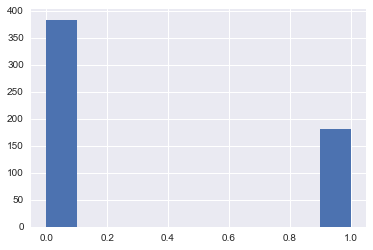

In [9]:
#check if the dataset is balanced 
df.Classification.hist()
#'not jump' is twice as many  

In [10]:
##EDA
def plot_axis(ax, x, y, title):
    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)
    
def plot_accel(activity):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 10), sharex=True)
    plot_axis(ax0, activity['Timestamp'], activity['xAccel'], 'xAccel')
    plot_axis(ax1, activity['Timestamp'], activity['yAccel'], 'yAccel')
    plot_axis(ax2, activity['Timestamp'], activity['yAccel'], 'zAccel')
    plt.subplots_adjust(hspace=0.2)
    plt.show()
    

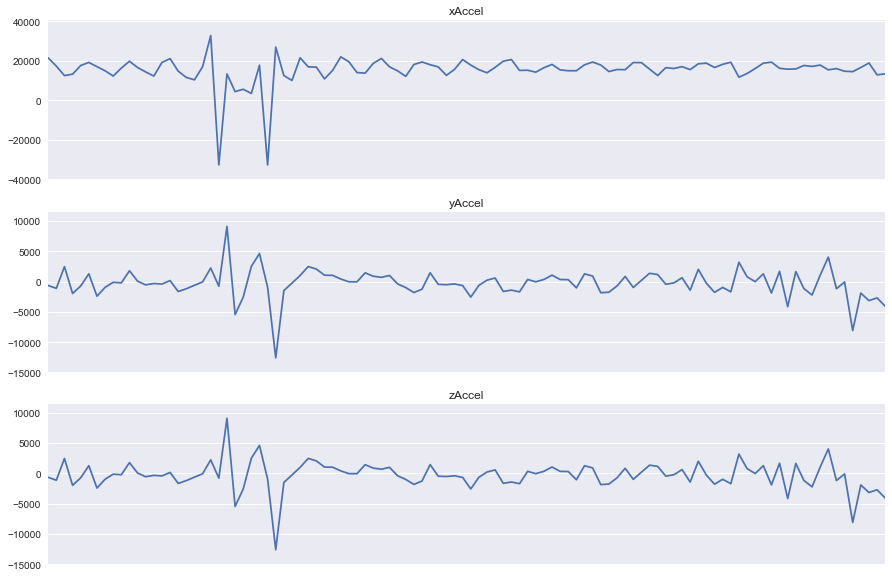

In [213]:
##jump 
plot_accel(dic['REVL0003'][0])

In [194]:
df[df.Classification==0].head(1)

,Filename,Classification,Description
180,REVL0444,0,Variety of motions


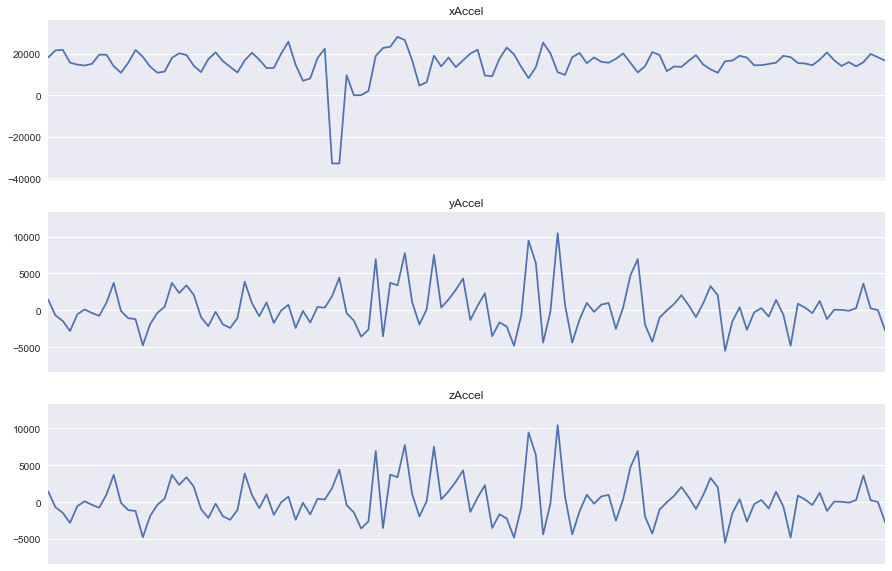

In [214]:
#not jump 
plot_accel(dic['REVL0444'][0])

In [722]:
def plot_gyro(activity):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 10), sharex=True)
    plot_axis(ax0, activity['Timestamp'], activity['xGyro'], 'xGyro')
    plot_axis(ax1, activity['Timestamp'], activity['yGyro'], 'yGyro')
    plot_axis(ax2, activity['Timestamp'], activity['yGyro'], 'zGyro')
    plt.subplots_adjust(hspace=0.2)
    plt.show()
    

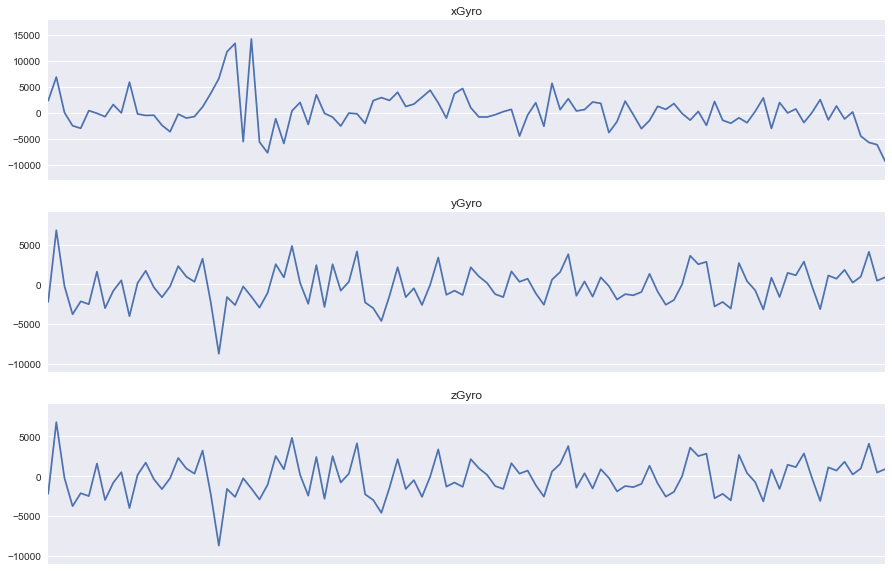

In [207]:
##jump 
plot_gyro(dic['REVL0003'][0])

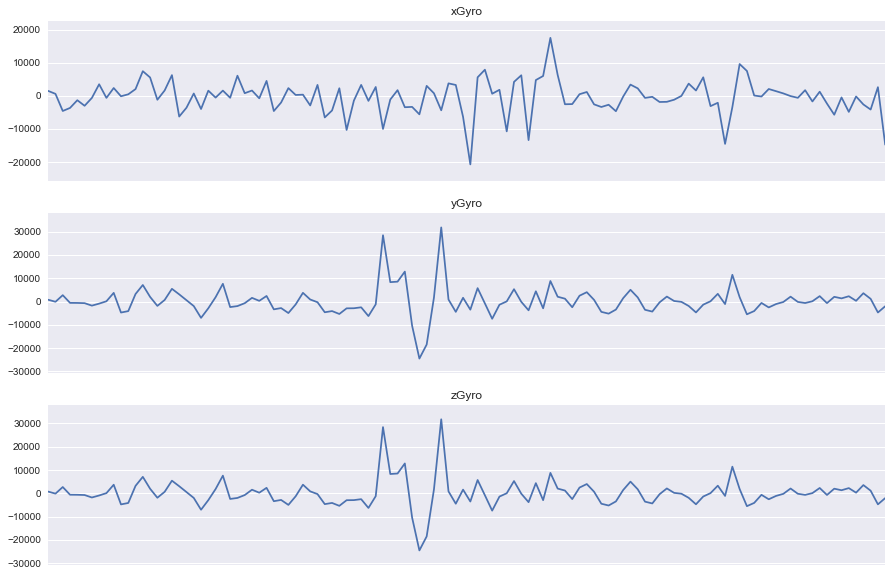

In [208]:
##not jump 
plot_gyro(dic['REVL0444'][0])

In [209]:
def plot_magnet(activity):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 10), sharex=True)
    plot_axis(ax0, activity['Timestamp'], activity['xMagnet'], 'xMagnet')
    plot_axis(ax1, activity['Timestamp'], activity['yMagnet'], 'yMagnet')
    plot_axis(ax2, activity['Timestamp'], activity['yMagnet'], 'zMagnet')
    plt.subplots_adjust(hspace=0.2)
    plt.show()


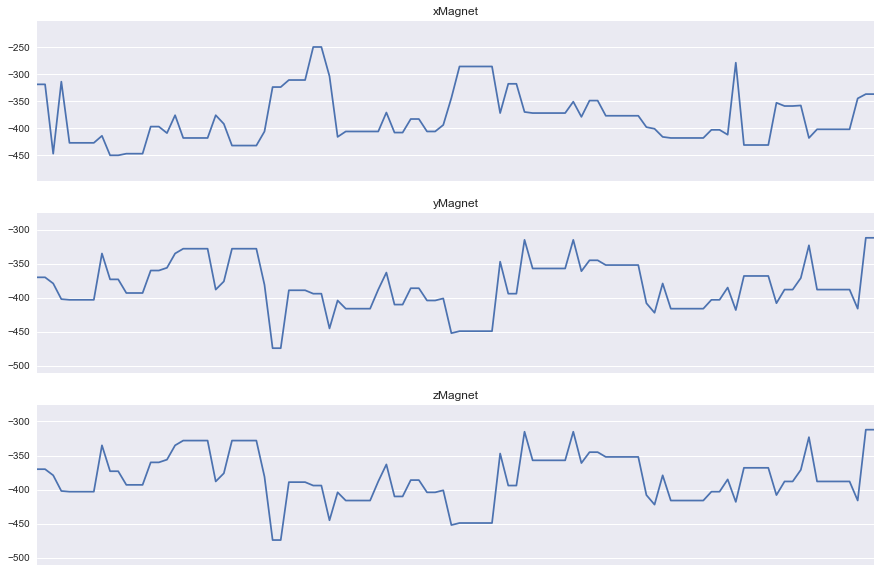

In [210]:
##jump 
plot_magnet(dic['REVL0003'][0])

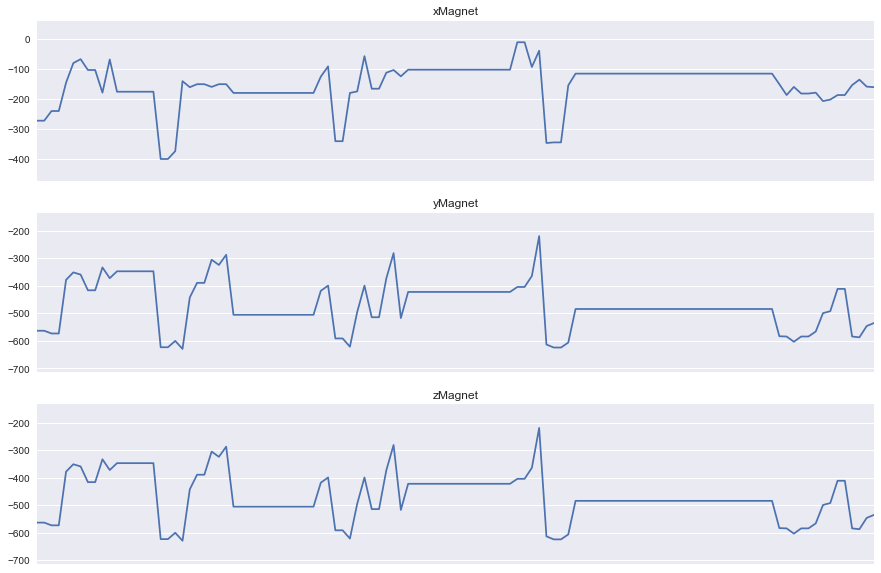

In [211]:
##not jump 
plot_magnet(dic['REVL0444'][0])

In [273]:
def plot_angle(activity1, activity2):
    fig, (ax0,ax1) = plt.subplots(nrows=2, figsize=(15, 10), sharex=True)
    plot_axis(ax0, activity1['Timestamp'], activity1['Angle'], 'Angle jump')
    plot_axis(ax1, activity2['Timestamp'], activity2['Angle'],  'Angle no jump')
    plt.subplots_adjust(hspace=0.2)
    plt.show()

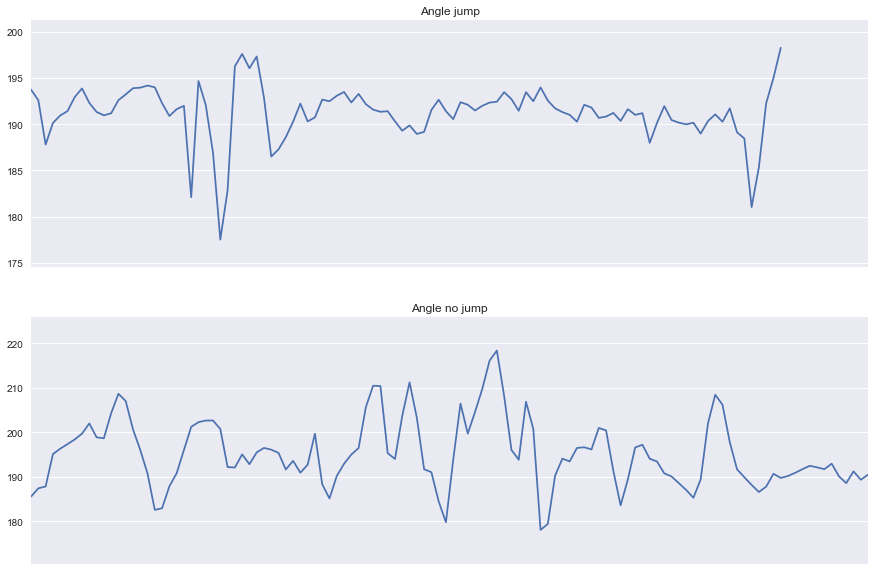

In [274]:
plot_angle(dic['REVL0003'][0], dic['REVL0444'][0])

In [ ]:
## Accels/Gyros =aligment of x, y, z over time angle=magnitude could be the differentiators 

In [11]:
## look at magnitude with x, y z accels combined 

def magnitude(activity):
    x2 = activity['xAccel'] * activity['xAccel']
    y2 = activity['yAccel'] * activity['yAccel']
    z2 = activity['zAccel'] * activity['zAccel']
    m2 = x2 + y2 + z2
    m = m2.apply(lambda x: math.sqrt(x))
    return m

In [15]:
Jump=  dic['REVL0003'][0]
NoJump= dic['REVL0444'][0]
Jump['mAccel'] = magnitude(Jump)
NoJump['mAccel']=magnitude(NoJump)

In [19]:
def plot_magnitudes(activities, titles):
    fig, axs = plt.subplots(nrows=len(activities), figsize=(15, 15))
    for i in range(0, len(activities)):
        plot_axis(axs[i], activities[i]['Timestamp'], activities[i]['mAccel'], titles[i])
    plt.subplots_adjust(hspace=0.2)
    plt.show()

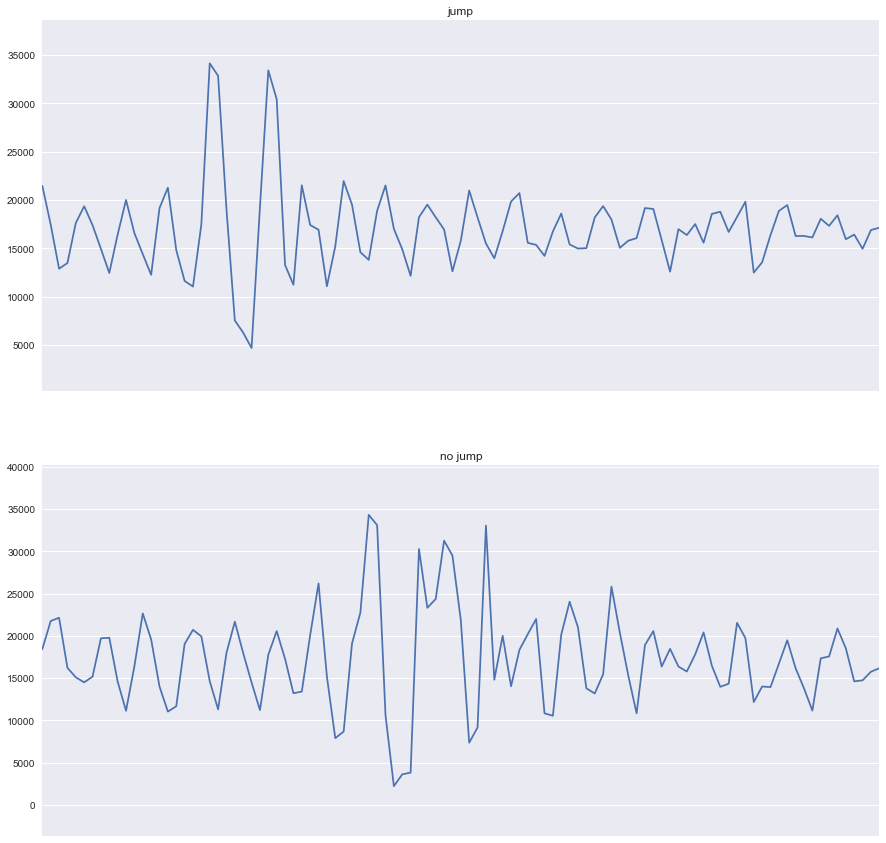

In [20]:
activities=[Jump, NoJump]
titles=['jump', 'no jump']
plot_magnitudes(activities, titles) 

In [46]:
# adding a new col to train dataset 
for key, value in dic.items():
    value[0]['mAccel']=magnitude(value[0])
    #print value[0]

In [51]:
def magnitude_gyro(activity):
    x2 = activity['xGyro'] * activity['xGyro']
    y2 = activity['yGyro'] * activity['yGyro']
    z2 = activity['zGyro'] * activity['zGyro']
    m2 = x2 + y2 + z2
    m = m2.apply(lambda x: math.sqrt(x))
    return m

In [52]:
for key, value in dic.items():
    value[0]['mGryo']=magnitude_gyro(value[0])
    #print value[0]

In [54]:
dic['REVL0003'][0].head(3)

,Timestamp,xAccel,yAccel,zAccel,xGyro,yGyro,zGyro,xMagnet,yMagnet,zMagnet,Angle,mAccel,mGryo
0,0,21448,-652,292,2302,-2212,-2568,-319,-370,41,193.722,21459.894501,4097.166338
1,100,17272,-1132,2252,6848,6796,-4120,-319,-370,41,192.579,17454.939473,10490.715895
2,200,12476,2456,2032,42,-226,-1104,-447,-379,123,187.784,12876.782828,1127.677259


In [81]:
# we also want to normalize the features so they are on the same scale 

for key, value in dic.items():
    
    max_gryo= value[0]['mGryo'].max()
    min_gryo= value[0]['mGryo'].min()
    max_accel=value[0]['mAccel'].max()
    min_accel=value[0]['mAccel'].min()
    max_angle=value[0]['Angle'].max()
    min_angle=value[0]['Angle'].min()
    
    value[0]['mGryo_norm']= value[0]['mGryo']/(max_gryo-min_gryo)
    value[0]['mAccel_norm']= value[0]['mAccel']/(max_accel-min_accel)
    value[0]['Angle_norm']= value[0]['Angle']/(max_angle-min_angle)


In [82]:
dic['REVL0003'][0].head(3)
#Angle is still 10x larger 

,Timestamp,xAccel,yAccel,zAccel,xGyro,yGyro,zGyro,xMagnet,yMagnet,zMagnet,Angle,mAccel,mGryo,mGryo_norm,mAccel_norm,Angle_norm
0,0,21448,-652,292,2302,-2212,-2568,-319,-370,41,193.722,21459.894501,4097.166338,0.261092,0.728079,9.643668
1,100,17272,-1132,2252,6848,6796,-4120,-319,-370,41,192.579,17454.939473,10490.715895,0.668522,0.592201,9.586768
2,200,12476,2456,2032,42,-226,-1104,-447,-379,123,187.784,12876.782828,1127.677259,0.071861,0.436876,9.348068


In [83]:
for key, value in dic.items():
    
    value[0]['Angle_norm']= value[0]['Angle_norm']/10


In [84]:
dic['REVL0003'][0].head(3)
#Now we can use mAccel_norm, mGryo_norm, Angle_norm as raw features in each window (used in window summary later )

,Timestamp,xAccel,yAccel,zAccel,xGyro,yGyro,zGyro,xMagnet,yMagnet,zMagnet,Angle,mAccel,mGryo,mGryo_norm,mAccel_norm,Angle_norm
0,0,21448,-652,292,2302,-2212,-2568,-319,-370,41,193.722,21459.894501,4097.166338,0.261092,0.728079,0.964367
1,100,17272,-1132,2252,6848,6796,-4120,-319,-370,41,192.579,17454.939473,10490.715895,0.668522,0.592201,0.958677
2,200,12476,2456,2032,42,-226,-1104,-447,-379,123,187.784,12876.782828,1127.677259,0.071861,0.436876,0.934807


In [93]:
def windows(df, size=10):  
    start = 0
    while start < df.count():
        yield start, start + size
        start += (size / 2)
        

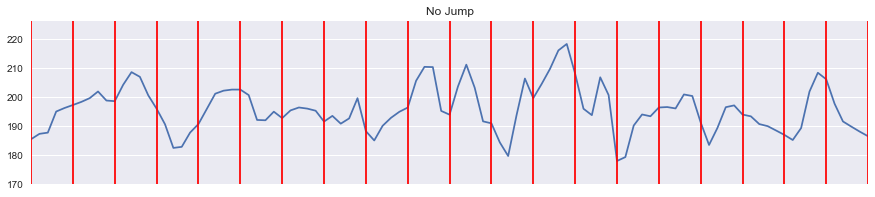

In [94]:
fig, ax = plt.subplots(nrows=1, figsize=(15, 3))
plot_axis(ax, dic['REVL0444'][0]['Timestamp'], dic['REVL0444'][0]['Angle'], 'No Jump')

for (start, end) in windows(dic['REVL0444'][0]['Timestamp']):
    ax.axvline(dic['REVL0444'][0]['Timestamp'][start], color='r')
    
plt.show()


In [119]:
def jitter(axis, start, end):
    j = float(0)
    for i in xrange(start, min(end, axis.count())):
        if start != 0:
            j += abs(axis[i] - axis[i-1])
    return j / (end-start)

def mean_crossing_rate(axis, start, end):
    cr = 0
    m = axis.mean()
    for i in xrange(start, min(end, axis.count())):
        if start != 0:
            p = axis[i-1] > m
            c = axis[i] > m
            if p != c:
                cr += 1
    return float(cr) / (end-start-1)

def window_summary(axis, start, end):
    acf = stattools.acf(axis[start:end])
    acv = stattools.acovf(axis[start:end])
    sqd_error = (axis[start:end] - axis[start:end].mean()) ** 2
    return [
        jitter(axis, start, end),     
        mean_crossing_rate(axis, start, end),
        axis[start:end].mean(),
        axis[start:end].std(),
        axis[start:end].var(),
        axis[start:end].min(),
        axis[start:end].max(),
        acf.mean(), # mean auto correlation
        acf.std(), # standard deviation auto correlation
        acv.mean(), # mean auto covariance
        acv.std(), # standard deviation auto covariance
        skew(axis[start:end]),
        kurtosis(axis[start:end]),
        math.sqrt(sqd_error.mean())
    ]

def features_func(activity):
    for (start, end) in windows(activity['Timestamp'][:-1]):
        features_array = []
        for axis in ['mAccel_norm', 'mGryo_norm', 'Angle_norm']:
            features_array += window_summary(activity[axis], start, end)
        yield features_array

In [110]:
def features_func2(activity):
    for (start, end) in windows(activity['Timestamp'][:-1]):
        features_array = []
        for axis in ['mAccel_norm', 'mGryo_norm', 'Angle_norm']:
            features_array += window_summary(activity[axis], start, end)
        return features_array 
    

In [96]:
NoJump=[dic.values()[i][0] for i in range(len(dic)) if dic.values()[i][1]==0 ] 
Jump=[dic.values()[i][0] for i in range(len(dic)) if dic.values()[i][1]==1 ]

In [97]:
activities = [NoJump, Jump]

In [120]:
with open('../Data/Features.csv', 'w') as out:
    rows = csv.writer(out)
    for i in range(0, len(activities)):
        for j in range(0, len(activities[i])):
            for f in features_func(activities[i][j]):
                rows.writerow([i] + f) 

In [124]:
dataset = np.loadtxt('../Data/Features.csv', delimiter=",")
X = dataset[:, 1:]
X=np.nan_to_num(X)
y = dataset[:, 0]

In [117]:
X.shape, y.shape , df.shape
#6/3=2 features 
#20 timewindows

((11091, 6), (11091,), (563, 3))

In [125]:
rfc = RandomForestClassifier()
svc=SVC()
base = DummyClassifier() # generates baseline predictions
rfc_res = []
svc_res=[]
baselines = []

for i in range(0, 10):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    rfc.fit(X_train, y_train)
    svc.fit(X_train, y_train)
    base.fit(X_train, y_train)
    rfc_score = rfc.score(X_test, y_test)
    svc_score=svc.score(X_test, y_test)
    base_score = base.score(X_test, y_test)
    print 'Loop', i, rfc_score, svc_score,  base_score
    rfc_res.append(rfc_score)
    svc_res.append(svc_score)
    baselines.append(base_score)


print '\nBaseline', np.mean(baselines), np.std(baselines)
print 'SVC', np.mean(svc_res), np.std(svc_res)
print 'Random Forest', np.mean(rfc_res), np.std(rfc_res)

Loop 0 0.965380454382 0.96321673278 0.553912729895
Loop 1 0.960692390912 0.95636494771 0.571583122972
Loop 2 0.961774251713 0.959249909845 0.572304363505
Loop 3 0.955643707176 0.953840605842 0.563649477101
Loop 4 0.962495492247 0.957807428777 0.569058781103
Loop 5 0.960692390912 0.957086188244 0.568698160837
Loop 6 0.959249909845 0.952037504508 0.573386224306
Loop 7 0.964659213848 0.96213487198 0.5625676163
Loop 8 0.958528669311 0.957446808511 0.558600793365
Loop 9 0.957807428777 0.956004327443 0.565452578435

Baseline 0.565921384782 0.00600419207371
SVC 0.957518932564 0.00322870959763
Random Forest 0.960692390912 0.00287593249728


In [126]:
rfc.feature_importances_ #mAccels_norm min, Angel_norm min, max are the top 3 features 

array([  3.63438699e-03,   1.62550243e-03,   9.59262007e-02,
         4.37657476e-03,   7.66307116e-03,   1.03452779e-01,
         9.24715956e-02,   6.57135605e-05,   1.29430171e-02,
         1.40027259e-02,   1.50399564e-02,   3.55185943e-03,
         4.71371874e-03,   2.98478511e-02,   4.26342322e-03,
         1.92448407e-03,   2.75593218e-02,   5.49849660e-03,
         3.43670499e-02,   1.94719666e-02,   3.67348631e-03,
         1.64730705e-04,   5.44269764e-03,   1.14441090e-02,
         3.59579494e-03,   4.26361794e-03,   4.96763062e-03,
         4.55601712e-03,   6.46818186e-03,   2.29217809e-03,
         1.02332100e-01,   9.81483235e-03,   4.06954732e-03,
         2.16129439e-01,   1.13990485e-01,   4.61177543e-05,
         3.95867229e-03,   3.75359684e-03,   6.16418061e-03,
         3.33232279e-03,   3.49462136e-03,   3.64594605e-03])

In [211]:
#prediction 
df_validation=pd.read_csv('TestDataClassification.csv')
df_validation['Classification']=0
keys=list(df_validation.Filename)
dic_val = OrderedDict(zip(keys, zip(features, df_validation.Classification))) 


In [212]:
dic_val.items()[1][0]

'REVL0037'

In [213]:
#data transformation 
# adding a new col to train dataset 
for key, value in dic_val.items():
    value[0]['mAccel']=magnitude(value[0])
    #print value[0]
    


In [214]:
for key, value in dic_val.items():
    value[0]['mGryo']=magnitude_gyro(value[0])
    #print value[0]

In [215]:
# we also want to normalize the features so they are on the same scale 

for key, value in dic_val.items():
    
    max_gryo= value[0]['mGryo'].max()
    min_gryo= value[0]['mGryo'].min()
    max_accel=value[0]['mAccel'].max()
    min_accel=value[0]['mAccel'].min()
    max_angle=value[0]['Angle'].max()
    min_angle=value[0]['Angle'].min()
    
    value[0]['mGryo_norm']= value[0]['mGryo']/(max_gryo-min_gryo)
    value[0]['mAccel_norm']= value[0]['mAccel']/(max_accel-min_accel)
    value[0]['Angle_norm']= value[0]['Angle']/(max_angle-min_angle)



In [216]:
for key, value in dic_val.items():
    
    value[0]['Angle_norm']= value[0]['Angle_norm']/10


In [144]:
dic_val['REVL0037'][0].head(3)

,Timestamp,xAccel,yAccel,zAccel,xGyro,yGyro,zGyro,xMagnet,yMagnet,zMagnet,Angle,mAccel,mGryo,mGryo_norm,mAccel_norm,Angle_norm
0,0,16700,-2288,-2140,-430,1802,-2074,-312,-400,311,195.507,16991.307896,2780.931499,0.163315,0.647985,1.202454
1,100,13808,-208,-940,144,2440,-44,-305,-453,309,194.947,13841.521882,2444.641487,0.143565,0.527864,1.199010
2,200,12360,720,-1304,1130,-832,1594,-366,-388,340,192.568,12449.434365,2123.666641,0.124716,0.474775,1.184378


In [217]:
NoJump=[dic_val.values()[i][0] for i in range(len(dic_val))] 
Jump=[]

In [218]:
activities=[NoJump, Jump]
len(activities)

2

In [219]:
with open('../Data/Features_Val.csv', 'w') as out:
    rows = csv.writer(out)
    for i in range(0, len(activities)):
        for j in range(0, len(activities[i])):
            for f in features_func(activities[i][j]):
                rows.writerow([i] + f) 

In [220]:
dataset = np.loadtxt('../Data/Features_Val.csv', delimiter=",")
X_test = dataset[:, 1:]
X_test=np.nan_to_num(X_test)
y_test = dataset[:, 0] 


In [221]:
y_pred=rfc.predict(X_test) 

In [222]:
X_test.shape, y_test.shape

((798, 42), (798,))

In [223]:
pred=[]
for i in np.array(range(798))[::20]:
    
    if np.any(y_pred[i:i+20]) =='0': 
        pred.append(1)
    else: 
        pred.append(0)      

In [196]:
len(df_validation), len(pred)

(40, 40)

In [224]:
df_validation.Classification=pred

In [227]:
with open('../Data/test2.csv', 'w') as out:
    rows = csv.writer(out)
    for i in range(0, df_validation.shape[0]):
        rows.writerow(df_validation.iloc[i,:]) 


In [230]:
df_validation.head(2)

,Filename,Classification,Description
0,REVL0009,0,NaN
1,REVL0037,0,NaN
